In [2]:
from qutipy import *
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar,fminbound
from opt_policy_1link_sats import *

In [3]:
def key_rate_6state_asymptotic(Q):
    
    return max([0,1+(1-(3*Q/2))*np.log2(1-(3*Q/2))+(3*Q/2)*np.log2(Q/2)])


def key_rate_BB84_asymptotic(Q):
    
    return max([0,1-2*bin_entropy(Q)])


def key_rate_DI_asymptotic(Q):
    
    S=2*np.sqrt(2)*(1-2*Q)
    
    return max([0,1-bin_entropy(Q)-bin_entropy((1/2)*(1+np.sqrt((S/2)**2-1)))])


def key_rate_BB84_asymptotic_optimize(Q):
    
    I_XY=1-bin_entropy(Q)
    
    def objfunc(s):
        
        I_XE=entropy(np.matrix(np.diag([1-2*Q+s,Q-s,Q-s,s])))-bin_entropy(Q)

        return I_XY-I_XE
    
    ### This optimization can be solved analytically,
    ### and the optimal value of s is s_opt=Q^2.
    
    
    opt=fminbound(objfunc,0,Q)
    
    return max([0,objfunc(opt)]),opt


def extract_QBERs(rhoAB):
    
    P=su_generators(2)
    
    Sx=P[1]
    Sy=P[2]
    Sz=P[3]
    
    Qx=np.real((1/2)*(1-np.trace(tensor(Sx,Sx)*rhoAB)))
    Qy=np.real((1/2)*(1+np.trace(tensor(Sy,Sy)*rhoAB)))
    Qz=np.real((1/2)*(1-np.trace(tensor(Sz,Sz)*rhoAB)))
    
    return Qx,Qy,Qz
    
    
def QBER_BB84(rhoAB):
    
    Qx,Qy,_=extract_QBERs(rhoAB)
    
    return (1/2)*(Qx+Qy)



def QBER_6state(rhoAB):
    
    Qx,Qy,Qz=extract_QBERs(rhoAB)
    
    return (1/3)*(Qx+Qy+Qz)


def key_rate_BB84_sats(n1,eta1,n2,eta2,fs=1):
    
    rhoAB=get_initial_states(n1,eta1,n2,eta2,fs=fs,normalized=True,embed=False)
    
    Q=QBER_BB84(rhoAB)
    
    return key_rate_BB84_asymptotic(Q)


def key_rate_6state_sats(n1,eta1,n2,eta2,fs=1):
    
    rhoAB=get_initial_states(n1,eta1,n2,eta2,fs=fs,normalized=True,embed=False)
    
    Q=QBER_6state(rhoAB)
    
    return key_rate_6state_asymptotic(Q)


def BB84_region(D,H,n,fs=1,M=1,alt=False):
    
    eta=np.array([[eta_Tot(link_distance(d*1e3,h*1e3),h*1e3) for d in D] for h in H])
    
    X=(1-n)*eta+(n/2)*((1-2*eta)**2+eta**2)
    Y=(n/2)*(1-eta)**2
    Z=(1-n)*eta-n*eta*(1-2*eta)
    
    A=X**2+Y**2
    B=Z**2
    C=2*X*Y
    
    alpha=(1/(A+C))*((1/2)*fs*A+(1/2)*((1-fs)/3)*(A+2*C))
    beta=(1/(A+C))*((1/2)*fs*B-(1/2)*((1-fs)/3)*B)
    
    Q=(3/4)-(1/2)*beta-alpha
    
    if alt:
        P=(X+Y)**2
        K=M*P*(1-2*(-Q*np.log2(Q)-(1-Q)*np.log2(1-Q)))
    else:
        K=1-2*(-Q*np.log2(Q)-(1-Q)*np.log2(1-Q))
    
    K[K<=0]=None
    
    d,h=np.meshgrid(D,H)
    
    return d,h,K


def six_state_region(D,H,n,fs=1,M=1,alt=False):
    
    eta=np.array([[eta_Tot(link_distance(d*1e3,h*1e3),h*1e3) for d in D] for h in H])
    
    X=(1-n)*eta+(n/2)*((1-2*eta)**2+eta**2)
    Y=(n/2)*(1-eta)**2
    Z=(1-n)*eta-n*eta*(1-2*eta)
    
    A=X**2+Y**2
    B=Z**2
    C=2*X*Y
    
    alpha=(1/(A+C))*((1/2)*fs*A+(1/2)*((1-fs)/3)*(A+2*C))
    beta=(1/(A+C))*((1/2)*fs*B-(1/2)*((1-fs)/3)*B)
    
    Q=(2/3)*(1-(alpha+beta))
    
    if alt:
        P=(X+Y)**2
        K=M*P*(1+(1-(3*Q/2))*np.log2(1-(3*Q/2))+(3*Q/2)*np.log2(Q/2))
    else:
        K=1+(1-(3*Q/2))*np.log2(1-(3*Q/2))+(3*Q/2)*np.log2(Q/2)
    
    K[K<=0]=None
    
    d,h=np.meshgrid(D,H)
    
    return d,h,K


def DI_region(D,H,n,fs=1,M=1,alt=False):
    
    eta=np.array([[eta_Tot(link_distance(d*1e3,h*1e3),h*1e3) for d in D] for h in H])
    
    X=(1-n)*eta+(n/2)*((1-2*eta)**2+eta**2)
    Y=(n/2)*(1-eta)**2
    Z=(1-n)*eta-n*eta*(1-2*eta)
    
    A=X**2+Y**2
    B=Z**2
    C=2*X*Y
    
    alpha=(1/(A+C))*((1/2)*fs*A+(1/2)*((1-fs)/3)*(A+2*C))
    beta=(1/(A+C))*((1/2)*fs*B-(1/2)*((1-fs)/3)*B)
    
    Q=(2/3)*(1-(alpha+beta))
    S=2*np.sqrt(2)*(1-2*Q)
    
    if alt:
        P=(X+Y)**2
        K=M*P*(1-(-Q*np.log2(Q)-(1-Q)*np.log2(1-Q))-(-((1/2)*(1+np.sqrt((S/2)**2-1)))*np.log2((1/2)*(1+np.sqrt((S/2)**2-1)))-(1-((1/2)*(1+np.sqrt((S/2)**2-1))))*np.log2(1-((1/2)*(1+np.sqrt((S/2)**2-1))))))
    else:
        K=1-(-Q*np.log2(Q)-(1-Q)*np.log2(1-Q))-(-((1/2)*(1+np.sqrt((S/2)**2-1)))*np.log2((1/2)*(1+np.sqrt((S/2)**2-1)))-(1-((1/2)*(1+np.sqrt((S/2)**2-1))))*np.log2(1-((1/2)*(1+np.sqrt((S/2)**2-1)))))
    
    K[K<=0]=None
    
    d,h=np.meshgrid(D,H)
    
    return d,h,K
    
    

In [4]:
key_rate_6state_asymptotic(0.126)

0.0010672433996055108

In [5]:
Q_array=np.linspace(0,1,500)

In [6]:
K_BB84=[key_rate_BB84_asymptotic(Q) for Q in Q_array]
K_6state=[key_rate_6state_asymptotic(Q) for Q in Q_array]
K_6state[0]=1

<ipython-input-3-96e5eab6c1e7>:3: RuntimeWarning: divide by zero encountered in log2
  return max([0,1+(1-(3*Q/2))*np.log2(1-(3*Q/2))+(3*Q/2)*np.log2(Q/2)])
<ipython-input-3-96e5eab6c1e7>:3: RuntimeWarning: invalid value encountered in double_scalars
  return max([0,1+(1-(3*Q/2))*np.log2(1-(3*Q/2))+(3*Q/2)*np.log2(Q/2)])
<ipython-input-3-96e5eab6c1e7>:3: RuntimeWarning: invalid value encountered in log2
  return max([0,1+(1-(3*Q/2))*np.log2(1-(3*Q/2))+(3*Q/2)*np.log2(Q/2)])


In [7]:
K_DI=[key_rate_DI_asymptotic(Q) for Q in Q_array]

<ipython-input-3-96e5eab6c1e7>:15: RuntimeWarning: invalid value encountered in sqrt
  return max([0,1-bin_entropy(Q)-bin_entropy((1/2)*(1+np.sqrt((S/2)**2-1)))])


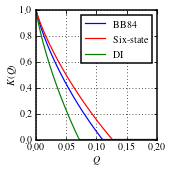

In [17]:
plt.figure(figsize=(2.5,2.5))

plt.plot(Q_array,K_BB84,color='blue',label=r'BB84')
plt.plot(Q_array,K_6state,color='red',label=r'Six-state')
plt.plot(Q_array,K_DI,color='green',label=r'DI')

plt.xlabel(r'$Q$',fontsize=10)
plt.ylabel(r'$K(Q)$',fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlim([0,0.2])
plt.ylim([0,1])

plt.legend(fontsize=10)

plt.tight_layout()

plt.savefig('key_rates.pdf',bbox_inches='tight')

plt.show()

In [8]:
L_array=np.linspace(100,2000,100)  # ground station distances (in km)
h_array=np.linspace(100,10000,5000) # satellite altitudes (in km)

In [9]:
#### Here, we compute the total transmittance to BOTH ground stations

eta_sg_h_500=[eta_Tot(link_distance(d*1e3,500e3),500e3)**2 for d in L_array]
eta_sg_h_1000=[eta_Tot(link_distance(d*1e3,1000e3),1000e3)**2 for d in L_array]
eta_sg_h_2000=[eta_Tot(link_distance(d*1e3,2000e3),2000e3)**2 for d in L_array]
eta_sg_h_3000=[eta_Tot(link_distance(d*1e3,3000e3),3000e3)**2 for d in L_array]
eta_sg_h_4000=[eta_Tot(link_distance(d*1e3,4000e3),4000e3)**2 for d in L_array]
eta_sg_h_5000=[eta_Tot(link_distance(d*1e3,5000e3),5000e3)**2 for d in L_array]

In [10]:
#### Here, we compute the total transmittance to BOTH ground stations

eta_sg_d_1000=[eta_Tot(link_distance(1000e3,h*1e3),h*1e3)**2 for h in h_array]
eta_sg_d_2000=[eta_Tot(link_distance(2000e3,h*1e3),h*1e3)**2 for h in h_array]
eta_sg_d_3000=[eta_Tot(link_distance(3000e3,h*1e3),h*1e3)**2 for h in h_array]
eta_sg_d_4000=[eta_Tot(link_distance(4000e3,h*1e3),h*1e3)**2 for h in h_array]
eta_sg_d_5000=[eta_Tot(link_distance(5000e3,h*1e3),h*1e3)**2 for h in h_array]
eta_sg_d_6000=[eta_Tot(link_distance(6000e3,h*1e3),h*1e3)**2 for h in h_array]

In [11]:
D_array=np.linspace(100,6000,700) # ground station distances (in km)
H_array=np.linspace(100,10000,700) # satellite altitudes (in km)

In [12]:
d,h,K_BB84=BB84_region(D_array,H_array,1e-4,fs=1)
d_alt,h_alt,K_BB84_alt=BB84_region(D_array,H_array,1e-4,fs=1,M=1e9,alt=True)

In [13]:
d2,h2,K_6state=six_state_region(D_array,H_array,1e-4,fs=1)
d2_alt,h2_alt,K_6state_alt=six_state_region(D_array,H_array,1e-4,fs=1,M=1e9,alt=True)

In [14]:
d3,h3,K_DI=DI_region(D_array,H_array,1e-4,fs=1)
d3_alt,h3_alt,K_DI_alt=DI_region(D_array,H_array,1e-4,fs=1,M=1e9,alt=True)

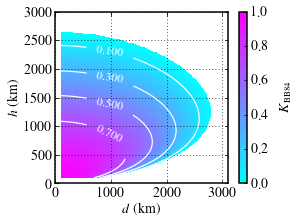

In [304]:
fig=plt.figure(figsize=(4.2,3.2))

plt.imshow(K_BB84,cmap='cool',aspect='auto',origin='lower',vmin=0,vmax=1,extent=[100,6000,100,10000])

#ax=sns.heatmap(fid_reg)

#plt.contourf(d,h,fid_reg,levels=[0.1,0.15,0.2,0.4,0.6,0.8,0.85,0.9,0.95,1])

cb=plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.set_label(r'$K_{\small\textnormal{BB84}}$',fontsize=14,labelpad=10)

CS=plt.contour(D_array,H_array,K_BB84,[0.10,0.30,0.5,0.7],colors='white')
plt.clabel(CS, inline=True, inline_spacing=0.0001, fontsize=12, manual=[(1000,2500),(1000,2000),(1000,1500),(1000,1000)])

plt.xlabel(r'$d$ (km)',fontsize=14)
plt.ylabel(f'$h$ (km)',fontsize=14)

plt.xlim([0,3100])
plt.ylim([0,3000])


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()

plt.savefig('key_rates_BB84.pdf',bbox_inches='tight')

plt.show()

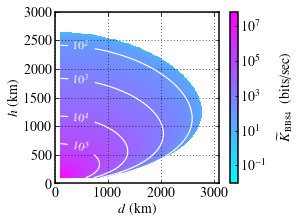

In [311]:
fig=plt.figure(figsize=(4.2,3.2))

plt.imshow(K_BB84_alt,cmap='cool',aspect='auto',origin='lower',extent=[100,6000,100,10000],norm=matplotlib.colors.LogNorm())

#ax=sns.heatmap(fid_reg)

#plt.contourf(d,h,fid_reg,levels=[0.1,0.15,0.2,0.4,0.6,0.8,0.85,0.9,0.95,1])

cb=plt.colorbar()
cb.ax.tick_params(labelsize=14)
#cb.ax.set_yticklabels([1e-4,1e-2,1,1e2,1e4,1e6])
#cb.ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
cb.set_label(r'$\widetilde{K}_{\small\textnormal{BB84}}~$ (bits/sec)',fontsize=14,labelpad=10)
#cb.formatter.set_powerlimits((0,0))
#cb.update_ticks()

CS=plt.contour(D_array,H_array,K_BB84_alt,[1e2,1e3,1e4,1e5],colors='white')
fmt=matplotlib.ticker.LogFormatterSciNotation()
plt.clabel(CS, inline=1, inline_spacing=0.001, fmt=fmt, fontsize=12, manual=[(500,2500),(500,1750),(500,1200),(500,700)])

plt.xlabel(r'$d$ (km)',fontsize=14)
plt.ylabel(f'$h$ (km)',fontsize=14)

plt.xlim([0,3100])
plt.ylim([0,3000])


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()

plt.savefig('key_rates_BB84_alt.pdf',bbox_inches='tight')

plt.show()

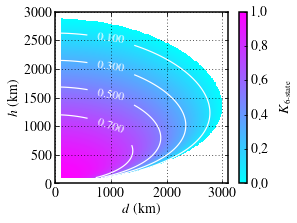

In [305]:
fig=plt.figure(figsize=(4.2,3.2))

plt.imshow(K_6state,cmap='cool',aspect='auto',origin='lower',vmin=0,vmax=1,extent=[100,6000,100,10000])

#ax=sns.heatmap(fid_reg)

#plt.contourf(d,h,fid_reg,levels=[0.1,0.15,0.2,0.4,0.6,0.8,0.85,0.9,0.95,1])

cb=plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.set_label(r'$K_{\small\textnormal{6-state}}$',fontsize=14,labelpad=10)

CS=plt.contour(D_array,H_array,K_6state,[0.10,0.30,0.5,0.7],colors='white')
plt.clabel(CS, inline=True, inline_spacing=0.001, fontsize=12, manual=[(1000,2500),(1000,2000),(1000,1500),(1000,1000)])

plt.xlabel(r'$d$ (km)',fontsize=14)
plt.ylabel(f'$h$ (km)',fontsize=14)

plt.xlim([0,3100])
plt.ylim([0,3000])


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()

plt.savefig('key_rates_6state.pdf',bbox_inches='tight')

plt.show()

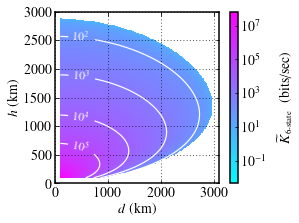

In [310]:
fig=plt.figure(figsize=(4.2,3.2))

plt.imshow(K_6state_alt,cmap='cool',aspect='auto',origin='lower',extent=[100,6000,100,10000],norm=matplotlib.colors.LogNorm())

#ax=sns.heatmap(fid_reg)

#plt.contourf(d,h,fid_reg,levels=[0.1,0.15,0.2,0.4,0.6,0.8,0.85,0.9,0.95,1])

cb=plt.colorbar()
cb.ax.tick_params(labelsize=14)
#cb.ax.set_yticklabels([1e-4,1e-2,1,1e2,1e4,1e6])
#cb.ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
cb.set_label(r'$\widetilde{K}_{\small\textnormal{6-state}}~$ (bits/sec)',fontsize=14,labelpad=10)
#cb.formatter.set_powerlimits((0,0))
#cb.update_ticks()

CS=plt.contour(D_array,H_array,K_6state_alt,[1e2,1e3,1e4,1e5],colors='white')
fmt=matplotlib.ticker.LogFormatterSciNotation()
plt.clabel(CS, inline=1, inline_spacing=0.001, fmt=fmt, fontsize=12, manual=[(500,2500),(500,1750),(500,1200),(500,700)])

plt.xlabel(r'$d$ (km)',fontsize=14)
plt.ylabel(f'$h$ (km)',fontsize=14)

plt.xlim([0,3100])
plt.ylim([0,3000])


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()

plt.savefig('key_rates_6state_alt.pdf',bbox_inches='tight')

plt.show()

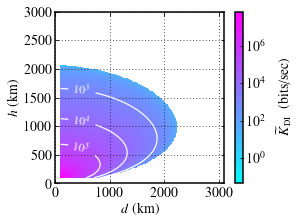

In [17]:
fig=plt.figure(figsize=(4.2,3.2))

plt.imshow(K_DI_alt,cmap='cool',aspect='auto',origin='lower',extent=[100,6000,100,10000],norm=matplotlib.colors.LogNorm())

#ax=sns.heatmap(fid_reg)

#plt.contourf(d,h,fid_reg,levels=[0.1,0.15,0.2,0.4,0.6,0.8,0.85,0.9,0.95,1])

cb=plt.colorbar()
cb.ax.tick_params(labelsize=14)
#cb.ax.set_yticklabels([1e-4,1e-2,1,1e2,1e4,1e6])
#cb.ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
cb.set_label(r'$\widetilde{K}_{\small\textnormal{DI}}~$ (bits/sec)',fontsize=14,labelpad=10)
#cb.formatter.set_powerlimits((0,0))
#cb.update_ticks()

CS=plt.contour(D_array,H_array,K_DI_alt,[1e3,1e4,1e5],colors='white')
fmt=matplotlib.ticker.LogFormatterSciNotation()
plt.clabel(CS, inline=1, inline_spacing=0.001, fmt=fmt, fontsize=12, manual=[(500,1750),(500,1200),(500,700)])

plt.xlabel(r'$d$ (km)',fontsize=14)
plt.ylabel(f'$h$ (km)',fontsize=14)

plt.xlim([0,3100])
plt.ylim([0,3000])


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()

plt.savefig('key_rates_DI_alt.pdf',bbox_inches='tight')

plt.show()